# Práctica 6 - Redes Neuronales

En esta práctica, a partir de unos datos médicos determinaremos si una persona a fallecido o no por un problema cardiovascular.

Cargamos nuestros datos desde fichero con Pandas.

In [2]:
import pandas as pd

data = pd.read_csv('historial_clinico.csv')
data

,edad,creatinina_fosfocinasa,diabetes,sangre_contraccion,plaquetas,creatinina,sodio,seguimiento,fallecimiento,anemia,tension,sexo,fumador
0,75,582,No,20,265000.00,1.9,130,4,1,No,muy alta,Hombre,ocasional
1,55,7861,No,38,263358.03,1.1,136,6,1,No,ligeramente alta,Hombre,ocasional
2,65,146,No,20,162000.00,1.3,129,7,1,No,ligeramente alta,Hombre,>2 paquetes/día
3,50,111,No,20,210000.00,1.9,137,7,1,Si,ligeramente alta,Hombre,ocasional
4,65,160,Sí,20,327000.00,2.7,116,8,1,Si,ligeramente alta,Mujer,ocasional
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62,61,Sí,38,155000.00,1.1,143,270,0,0,alta,masculino,sí
295,55,1820,No,38,270000.00,1.2,139,271,0,0,normal,femenino,no
296,45,2060,Sí,60,742000.00,0.8,138,278,0,0,normal,femenino,no
297,45,2413,No,38,140000.00,1.4,140,280,0,0,normal,masculino,sí


Viendo los valores mostrados, será necesario revisar todas las columnas de texto para que sean similares, por ejemplo la columna `sexo`.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   edad                    299 non-null    int64  
 1   creatinina_fosfocinasa  299 non-null    int64  
 2   diabetes                299 non-null    object 
 3   sangre_contraccion      299 non-null    int64  
 4   plaquetas               299 non-null    float64
 5   creatinina              299 non-null    float64
 6   sodio                   299 non-null    int64  
 7   seguimiento             299 non-null    int64  
 8   fallecimiento           299 non-null    int64  
 9   anemia                  298 non-null    object 
 10  tension                 299 non-null    object 
 11  sexo                    299 non-null    object 
 12  fumador                 299 non-null    object 
dtypes: float64(2), int64(6), object(5)
memory usage: 30.5+ KB


En principio no se detectan valores nulos con opción `info`.

Revisamos las columnas de tipo `object`.

In [4]:
data.diabetes.value_counts()

No    174
Sí    125
Name: diabetes, dtype: int64

`diabetes` solo tiene 2 valores posibles.

In [5]:
data.anemia.value_counts()

0     65
no    53
No    52
Si    48
Sí    47
1     33
Name: anemia, dtype: int64

En `anemia` tenemos mezclados valores tanto numéricos como de texto para dar un valor que debería ser binario.<br>
Procedemos a modificar estos datos, convirtiéndolos en 0 o 1, y dejando la columna de tipo numérico.

In [6]:
# PASS
# Modificar la columna anemia
tiene_anemia = {'no':'0', 
                'No':'0',
                'Si':'1',
                'Sí':'1'}
data.anemia.replace(tiene_anemia, inplace=True)

In [7]:
data.tension.value_counts()

normal              137
alta                 66
ligeramente alta     57
muy alta             39
Name: tension, dtype: int64

Para `tension` tenemos 4 posibles valores, por lo que no es necesaria ninguna actuación.

In [8]:
data.sexo.value_counts()

Hombre       66
Man          64
masculino    64
Woman        36
femenino     35
Mujer        34
Name: sexo, dtype: int64

En la columna `sexo` vemos como otro valor binario, está referenciado con múltiples valores.<br>
Se modifica para que solo tenga 2 valores posibles.

In [9]:
# PASS
# Modificación de la columna sexo
tipo_sexo = {'Man':'Hombre', 
                'masculino':'Hombre',
                'Woman':'Mujer',
                'femenino':'Mujer'}
data.sexo.replace(tipo_sexo, inplace=True)

In [10]:
data.fumador.value_counts()

no                 137
ocasional           66
sí                  66
>2 paquetes/día     30
Name: fumador, dtype: int64

Para `fumador` existen 4 valores bien diferenciados, por lo que no es necesario realizar ninguna modificación.

Realizamos la división de los datos de propiedades `X` y el valor a predecir `y`.

In [11]:
X = data.drop('fallecimiento', axis=1)
y = data.fallecimiento

Obtenemos las columnas numéricas de `X`.

In [12]:
col_num = [col for col in X.columns if not(str(X[col].dtype) in ('object')) ]
col_num

['edad',
 'creatinina_fosfocinasa',
 'sangre_contraccion',
 'plaquetas',
 'creatinina',
 'sodio',
 'seguimiento']

Estas columnas las vamos a normalizar con valores de 0 a 1 con la función `normalize` de Keras.

In [13]:
from tensorflow.keras.utils import normalize

for col in col_num:
    X[col] = normalize(X[col].values, axis=-1, order=10 )[0]

Veamos que columnas nos quedan como tipo `object` en `X`.

In [14]:
col_no_num = [col for col in X.columns if str(X[col].dtype) in ('object') ]
col_no_num

['diabetes', 'anemia', 'tension', 'sexo', 'fumador']

Vamos a realizar una doble conversión sobre estas columnas, las categorizaremos númericamente con la propia librería de Pandas, para sobre esa salida aplicar One Hot Encoder con `to_categorical` de Keras.<br>
Nota: esta función no está disponible en `tensorflow.keras`.

In [15]:
from keras.utils import np_utils

for col in col_no_num:
    X[col] = np_utils.to_categorical(X[col].astype('category').cat.codes)

Veamos la distribución de `X` ya que nos será necesario para la creación de la red neuronal.

In [16]:
X.shape

(299, 12)

Nuestro tensor de entrada tiene 299 ejemplos con 12 propiedades.

Dividimos nuestros DataFrame en los datos de entrenamiento y test.

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    stratify=y,
    shuffle=True,
    test_size=0.3)

Comenzamos con la creación de nuestra red neuronal.<br>
Primero creamos nuestro `modelo` instanciándolo como `Sequential`.

In [18]:
from tensorflow.keras.models import Sequential

modelo = Sequential()

Añadimos las capas correspondientes.<br>
En nuestra primera capa Densa incluimos con `input_shape` la capa inicial que tendrá 12 neuronas.<br>
En esta capa, aplicamos el teorema de Kolmogorov para decidir cuantas neuronas pondremos, puesto que tenemos 12 neuronas de entrada, nuestra capa oculta debe tener entre 1 y 23 neuronas. Probaremos con 16, que es superior a la capa inicial, pero no llegamos al máximo teórico. También es potencia de 2, para optimización de uso de procesadores.<br>
Como propiedad de activación elegimos `relu`.<br>
Para la última capa que será nuestra salida, como nuestro dato a predecir es binario, incluimos una capa Densa de 1 neurona con activación `sigmoide`.

In [19]:
from tensorflow.keras.layers import Dense

# Primera capa y capa oculta
modelo.add(Dense(16, 
                input_shape=(12,) , 
                activation='relu',
                name='capa_oculta'))

# Capa de salida
modelo.add(Dense(1, 
                 activation='sigmoid',
                 name='capa_salida'))

Veamos como queda gráficamente.

In [20]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 capa_oculta (Dense)         (None, 16)                208       
                                                                 
 capa_salida (Dense)         (None, 1)                 17        
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


Configuramos y compilamos la red.

In [21]:
modelo.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics='accuracy'
    )

Entrenamos el modelo haciendo 50 pasadas (`epoch`) con un `batch_size` de 2, ya que el número de muestras es solo de 299.

In [22]:
history = modelo.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=2,
                    epochs = 50,
                    verbose=False)

Veamos la evaluación de nuestra red.

In [23]:
loss, acc = modelo.evaluate(X_test, y_test, verbose=0)
print("Test loss:", loss)
print("Test accuracy:", acc)

Test loss: 0.00027115564444102347
Test accuracy: 1.0


Tenemos un acierto del 100% con una perdida de casi cero.

Mostremos gráficamente la relación entre el acierto y la perdida para ver como de optimizable es la red, visto por cada uno de los `epoch` realizado durante el entrenamiento.

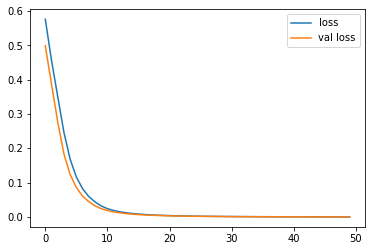

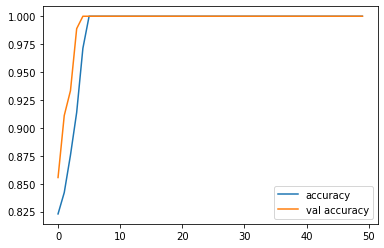

In [24]:
import matplotlib.pyplot as plt 
epochs = len(history.history['loss'])
plt.plot(
    range(0, epochs), history.history['loss'], 
    label='loss')
plt.plot(
    range(0, epochs), history.history['val_loss'], 
    label='val loss')
plt.legend()
plt.show()
plt.plot(
    range(0, epochs), history.history['accuracy'], 
    label='accuracy')
plt.plot(
    range(0, epochs), history.history['val_accuracy'], 
    label='val accuracy')
plt.legend()
plt.show()


En nuestro caso, para optimizar la red podríamos bajar el número de `epoch` posiblemente a solo 10, incluso algo menos, ya que el acierto está ya en 1 y es donde se empieza a aplanar la curva de perdida. También podríamos bajar la cantidad de neuronas, es cuestión de ir probando.

In [32]:
modelo2 = Sequential()

# Una sola Capa de salida
modelo2.add(Dense(1, 
                input_shape=(12,) , 
                activation='sigmoid',
                name='capa_salida'))

modelo2.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics='accuracy'
    )

history = modelo2.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=2,
                    epochs = 15,
                    verbose=False)

loss, acc = modelo2.evaluate(X_test, y_test, verbose=0)
print("Test loss:", loss)
print("Test accuracy:", acc)

Test loss: 0.3109045624732971
Test accuracy: 0.9333333373069763


Reduciendo a una sola capa neuronal y cambiando a `epoch` = 15, el modelo pasa a tener un acierto del 93%.
Modificando los parametros podemos llegar a un termino intermedio.